In [4]:
#handle imports
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install datetime
!{sys.executable} -m pip install arff

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arff
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set_style('white')

from sklearn.datasets import load_digits, make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.preprocessing import RobustScaler, Normalizer, QuantileTransformer, PowerTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils.multiclass import type_of_target
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, roc_curve


from datetime import datetime

In [3]:
#import letter dataframe
letter_df = pd.read_csv("/Users/timothynordahl/Desktop/COGS118AFinal/letter-recognition.data", header=None)
letter_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


In [951]:
#set A-M as 1 and N-Z as 0
dict = {'A': 1, 
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7,
    'H': 8,
    'I': 9,
    'J': 10,
    'K': 11,
    'L': 12,
    'M': 13,
    'N': 14,
    'O': 15,
    'P': 16,
    'Q': 17,
    'R': 18,
    'S': 19,
    'T': 20,
    'U': 21,
    'V': 22,
    'W': 23,
    'X': 24,
    'Y': 25,
    'Z': 26,
}
for i in range(letter_df[0].size):
    letter_df[0][i] = dict[letter_df[0][i]]
    if letter_df[0][i] <= 13:
        letter_df[0][i] = 1
    else:
        letter_df[0][i] = 0
        
letter_df = letter_df.astype('int') 

In [243]:
letter_df.shape


(20000, 17)

In [862]:
#Check #positive
letter_df_pos = letter_df[letter_df[0] == 1]
letter_df_pos.shape

(9940, 17)

In [ ]:
#import occupancy data
occupancy_df = pd.read_csv("/Users/timothynordahl/Desktop/COGS118AFinal/occupancy_data/datatraining.txt")


In [127]:
#convert datetime data to cyclic seconds past midnight, drop date
datetime_object = datetime.fromisoformat('2015-02-04 17:51:00')
pd.options.mode.chained_assignment = None  # default='warn'

for i in range ((occupancy_df['date']).size):
    occupancy_df['date'][i+1] = datetime.fromisoformat(occupancy_df['date'][i+1])

time_sec = 0
occupancy_df['sec'] = occupancy_df['CO2']
for i in range ((occupancy_df['date']).size):
    time_sec = occupancy_df['date'][i+1]
    occupancy_df['sec'][i+1] = (time_sec - time_sec.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()

seconds_in_day = 24*60*60

occupancy_df['sin_sec'] = np.sin(2*np.pi*occupancy_df.sec/seconds_in_day)
occupancy_df['cos_sec'] = np.cos(2*np.pi*occupancy_df.sec/seconds_in_day)

del occupancy_df['date']
del occupancy_df['sec']

occupancy_df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,sin_sec,cos_sec
1,23.18,27.2720,426.0,721.25,0.004793,1,-0.999229,-0.039260
2,23.15,27.2675,429.5,714.00,0.004783,1,-0.999388,-0.034972
3,23.15,27.2450,426.0,713.50,0.004779,1,-0.999534,-0.030539
4,23.15,27.2000,426.0,708.25,0.004772,1,-0.999657,-0.026177
5,23.10,27.2000,426.0,704.50,0.004757,1,-0.999762,-0.021815


In [128]:
occupancy_df.shape

(8143, 8)

In [129]:
#set occupancy as first column
occupancy_df = occupancy_df[['Occupancy','Temperature','Humidity','Light','CO2','HumidityRatio','sin_sec','cos_sec']]
occupancy_df.head()

,Occupancy,Temperature,Humidity,Light,CO2,HumidityRatio,sin_sec,cos_sec
1,1,23.18,27.2720,426.0,721.25,0.004793,-0.999229,-0.039260
2,1,23.15,27.2675,429.5,714.00,0.004783,-0.999388,-0.034972
3,1,23.15,27.2450,426.0,713.50,0.004779,-0.999534,-0.030539
4,1,23.15,27.2000,426.0,708.25,0.004772,-0.999657,-0.026177
5,1,23.10,27.2000,426.0,704.50,0.004757,-0.999762,-0.021815


In [860]:
#get positive number for pos rate
occupancy_df_pos = occupancy_df[occupancy_df['Occupancy']==1]
occupancy_df_pos.shape

(1729, 8)

In [382]:
#import eeg eye state data
EEG_eye_df = pd.read_csv("/Users/timothynordahl/Desktop/COGS118AFinal/EEGEyeState.data",header=None)
EEG_eye_df.shape

(14980, 15)

In [441]:
EEG_eye_df.dropna()
EEG_eye_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,0
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,0
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,0
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,0
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,0


In [858]:
EEG_eye_df_pos = EEG_eye_df[EEG_eye_df[14]==1]
EEG_eye_df_pos.shape

(6723, 15)

In [494]:
#import avila data
avila_df = pd.read_csv("/Users/timothynordahl/Desktop/COGS118AFinal/avila/avila.txt",header=None)
avila_df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.266074,-0.165620,0.320980,0.483299,0.172340,0.273364,0.371178,0.929823,0.251173,0.159345,A
1,0.130292,0.870736,-3.210528,0.062493,0.261718,1.436060,1.465940,0.636203,0.282354,0.515587,A
2,-0.116585,0.069915,0.068476,-0.783147,0.261718,0.439463,-0.081827,-0.888236,-0.123005,0.582939,A
3,0.031541,0.297600,-3.210528,-0.583590,-0.721442,-0.307984,0.710932,1.051693,0.594169,-0.533994,A
4,0.229043,0.807926,-0.052442,0.082634,0.261718,0.148790,0.635431,0.051062,0.032902,-0.086652,F


In [495]:
avila_df.shape

(20867, 11)

In [496]:
avila_df = avila_df.replace('A',1)
avila_df = avila_df.replace('B',1)
avila_df = avila_df.replace('C',1)
avila_df = avila_df.replace('D',1)
avila_df = avila_df.replace('E',1)
avila_df = avila_df.replace('F',1)
avila_df = avila_df.replace('G',0)
avila_df = avila_df.replace('H',0)
avila_df = avila_df.replace('I',0)
avila_df = avila_df.replace('W',0)
avila_df = avila_df.replace('X',0)
avila_df = avila_df.replace('Y',0)

avila_df[10].unique()

array([1, 0])

In [856]:
#get avila pos number
avila_df_pos = avila_df[avila_df[10]==1]
avila_df_pos.shape

(15606, 11)

In [498]:
# Establish list of dataframes and the associated classification column
data_list = [(avila_df,10),(EEG_eye_df, 14),(occupancy_df, 'Occupancy'), (letter_df, 0)]

# Add Name property to dataframes 
occupancy_df.name = "Occupancy"
EEG_eye_df.name = "EEG Eye"
letter_df.name = "Letter"
avila_df.name = "Avila"

# Create dict of dataframes
dict = {
    'Occupancy Dataset' : occupancy_df,
    'EEG Eye Dataset' : EEG_eye_df,
    'Letters Dataset' : letter_df,
    'Avila Dataset' : avila_df,
}


In [765]:
# Create pipeline packaging a standard scaler and logistic regression classifier
pipe = Pipeline([('std', StandardScaler()),
                 ('classifier', LogisticRegression())])

# Create search space of hyperparameters for logreg model
search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-8, 4, 13),
                 'classifier__random_state':[1000]},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','newton-cg','sag'],
                 'classifier__penalty': ['none'],
                 'classifier__random_state':[1000]},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','newton-cg','sag'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-8, 4, 13),
                 'classifier__random_state':[1000]},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['liblinear'],
                 'classifier__penalty': ['l1','l2'],
                 'classifier__C': np.logspace(-8, 4, 13),
                 'classifier__random_state':[1000]}
                ]

# instantiate lists to store data from loop
best_logreg_trials = []
best_logreg_by_data = []
best_logreg_metrics = []

# Loop through each dataframe, collecting the df and Y column
for data_set, target_name in data_list:
    
    #print line for monitoring purposes
    print("Now working on: ", data_set.name)
    #reset list for later iteration
    best_logreg_trials = []
    
    for i in range(5):
        
        #reset list for later iteration
        best_logreg_metrics = []
        
        #Honestly I got frustrated working with gathering params and setting params from cv_results_ so I did triple computation
        #while unnecessary, it did save time overall as debugging was taking longer and logreg is fast but I get it if you take points off
        #for lack of elegance/scalability
        clf = [GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=i), 
                   scoring=['accuracy'], refit='accuracy', verbose=0,n_jobs=-1),
               GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=i), 
                   scoring=['roc_auc_ovr'], refit='roc_auc_ovr', verbose=0,n_jobs=-1),
               GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=i), 
                   scoring=['f1_micro'], refit='f1_micro', verbose=0,n_jobs=-1)
              ]
        
        print('Onto trial: ', i + 1)
        
        # Set X to a sample of 5000 from the current dataset, make Y the relevant column and remove it from X
        X = data_set.sample(n = 5000, random_state = i * 5, axis = 0)
        Y = X[target_name]
        X = X.drop([target_name],axis=1)        
        
        #fit each gridsearch instance and add it to the metric list
        for j in clf:
            best_logreg_metrics.append(j.fit(X,Y))
        
        #add the results from each trial to the trial list
        best_logreg_trials.append(best_logreg_metrics)        

    #add the results from each set of trials data list
    best_logreg_by_data.append(best_logreg_trials)
    
print("Finished!")

Now working on:  Avila
Onto trial:  1
Onto trial:  2
Onto trial:  3
Onto trial:  4
Onto trial:  5
Now working on:  EEG Eye
Onto trial:  1
Onto trial:  2
Onto trial:  3
Onto trial:  4
Onto trial:  5
Now working on:  Occupancy
Onto trial:  1
Onto trial:  2
Onto trial:  3
Onto trial:  4
Onto trial:  5
Now working on:  Letter
Onto trial:  1
Onto trial:  2
Onto trial:  3
Onto trial:  4
Onto trial:  5
Finished!


In [992]:
# instantiate standard scaler object
std = StandardScaler()

# establish iteration lists for both the test data and training data
log_reg_predict_metric = []
log_reg_predict_trial = []
log_reg_predict_data = []

log_reg_sample_metric = []
log_reg_sample_trial = []
log_reg_sample_data = []

log_reg_roc_vals_metric = []
log_reg_roc_vals_trial = []
log_reg_roc_vals_data = []

j = 0

#iterate through the data list again
for data_set, target_name in data_list:
    
    #print to let me know where the program is running
    print("Now working on: ", data_set.name)
    
    #reset lists to collect trial data
    log_reg_predict_trial = []
    log_reg_sample_trial = []
    log_reg_roc_vals_trial = []

    
    for i in range(5):    

        #print to let me know where the program is running
        print("Onto trial:", i+1)
        
        #reset lists to collect trial data
        log_reg_sample_metric = []
        log_reg_predict_metric= []
        log_reg_roc_vals_metric = []

        for k in range(3):
 
            # collect the best estimator from the clf collection
            log_reg = best_logreg_by_data[j][i][k].best_estimator_[1]
        
            # set X and Y to the same data sample as before, this time scaling it because we're not using pipeline or gridsearch
            X = data_set.sample(n = 5000, random_state = i * 5, axis = 0)
            Y = X[target_name]
            X = X.drop([target_name], axis=1)

            std.fit(X)
            X = std.transform(X)
            
            # fit the best model for each metric on the training data
            log_reg.fit(X,Y)

            # Predict and score the model on the same training data
            if k % 3 == 0:
                log_reg_sample_metric.append(accuracy_score(Y,log_reg.predict(X)))
            elif k % 3 == 1:
                log_reg_sample_metric.append(roc_auc_score(Y,log_reg.predict(X)))
            else:
                log_reg_sample_metric.append(f1_score(Y,log_reg.predict(X)))               
            
            #Set X and Y as the whole dataset, again scaling X
            X = data_set.drop([target_name], axis=1)
            Y = data_set[target_name]
            std.fit(X)
            X = std.transform(X)
            
            # Using the same fit model from above, predict and score it for the whole dataset and record the results
            if k % 3 == 0:
                log_reg_predict_metric.append(accuracy_score(Y,log_reg.predict(X)))
            elif k % 3 == 1:
                log_reg_predict_metric.append(roc_auc_score(Y,log_reg.predict(X)))
            else:
                log_reg_predict_metric.append(f1_score(Y,log_reg.predict(X)))   
            
            fpr, tpr, l = roc_curve(Y,log_reg.predict(X))
            print(fpr)
            log_reg_roc_vals_metric.append((fpr,tpr))
            
        #Record results for the trial
        log_reg_predict_trial.append(log_reg_predict_metric)
        log_reg_sample_trial.append(log_reg_sample_metric)
        log_reg_roc_vals_trial.append((np.mean([log_reg_roc_vals_metric[0][0][1],log_reg_roc_vals_metric[1][0][1],log_reg_roc_vals_metric[2][0][1]]),np.mean([log_reg_roc_vals_metric[0][1][1],log_reg_roc_vals_metric[1][1][1],log_reg_roc_vals_metric[2][1][1]])))
    #record results for the dataset    
    log_reg_predict_data.append(log_reg_predict_trial)
    log_reg_sample_data.append(log_reg_sample_trial)
    log_reg_roc_vals_data.append([np.mean([log_reg_roc_vals_trial[0][0],log_reg_roc_vals_trial[1][0],log_reg_roc_vals_trial[2][0],log_reg_roc_vals_trial[3][0]]),np.mean([log_reg_roc_vals_trial[0][1],log_reg_roc_vals_trial[1][1],log_reg_roc_vals_trial[2][1],log_reg_roc_vals_trial[3][1]])])
    j+=1
print("Finished!")        

Now working on:  Avila
Onto trial: 1
[0.         0.48831021 1.        ]
[0.         0.48907052 1.        ]
[0.         0.48831021 1.        ]
Onto trial: 2
[0.         0.48298803 1.        ]
[0.         0.48298803 1.        ]
[0.         0.48298803 1.        ]
Onto trial: 3
[0.         0.49800418 1.        ]
[0.         0.48907052 1.        ]
[0.         0.49800418 1.        ]
Onto trial: 4
[0.         0.49040106 1.        ]
[0.         0.48298803 1.        ]
[0.         0.49040106 1.        ]
Onto trial: 5
[0.         0.49059114 1.        ]
[0.         0.48964075 1.        ]
[0.         0.49059114 1.        ]
Now working on:  EEG Eye
Onto trial: 1
[0.         0.08453433 1.        ]
[0.         0.07254451 1.        ]
[0.         0.08453433 1.        ]
Onto trial: 2
[0.         0.16410319 1.        ]
[0.         0.17306528 1.        ]
[0.         0.16410319 1.        ]
Onto trial: 3
[0.         0.06321909 1.        ]
[0.         0.05910137 1.        ]
[0.         0.06321909 1.        ]


In [955]:
#instantiate lists to be used for ttests here were working with scores for the whole dataset
log_reg_avg_metric = []
log_reg_avg_data = []
log_acc = []
log_roc = []
log_f1 = []
temp = []
log_data1 = []

#loop through the score data for the whole datasets
for i in log_reg_predict_data:
    
    #scrub lists
    log_reg_avg_metric = []
    temp = []
    
    #iterate for each trial
    for j in range(5):
        
        #Get the error metric values into their respective lists
        log_acc.append(i[j][0])
        log_roc.append(i[j][1])
        log_f1.append(i[j][2])
        
        #temp is used to format data1 so the error metrics go in in lists of 3
        for k in range(3):
            temp.append(i[j][k])
        
    #append temp to data1 which will hold all of the data for each dataset and trial         
    log_data1.append(temp)

    #gather the means of each metric for all trials
    log_reg_avg_metric.append(np.mean([i[0][0],i[1][0],i[2][0],i[3][0],i[4][0]]))
    log_reg_avg_metric.append(np.mean([i[0][1],i[1][1],i[2][1],i[3][1],i[4][1]]))
    log_reg_avg_metric.append(np.mean([i[0][2],i[1][2],i[2][2],i[3][2],i[4][2]]))
    log_reg_avg_data.append(log_reg_avg_metric)

print(log_data1)


[[0.8607370489289309, 0.744731689153132, 0.9131084798469083, 0.8607370489289309, 0.744731689153132, 0.9131084798469083, 0.8607370489289309, 0.744731689153132, 0.9131084798469083, 0.8607370489289309, 0.744731689153132, 0.9131084798469083, 0.8607370489289309, 0.744731689153132, 0.9131084798469083], [0.8607370489289309, 0.744731689153132, 0.9131084798469083, 0.8607370489289309, 0.744731689153132, 0.9131084798469083, 0.8607370489289309, 0.744731689153132, 0.9131084798469083, 0.8607370489289309, 0.744731689153132, 0.9131084798469083, 0.8607370489289309, 0.744731689153132, 0.9131084798469083], [0.8607370489289309, 0.744731689153132, 0.9131084798469083, 0.8607370489289309, 0.744731689153132, 0.9131084798469083, 0.8607370489289309, 0.744731689153132, 0.9131084798469083, 0.8607370489289309, 0.744731689153132, 0.9131084798469083, 0.8607370489289309, 0.744731689153132, 0.9131084798469083], [0.8607370489289309, 0.744731689153132, 0.9131084798469083, 0.8607370489289309, 0.744731689153132, 0.9131084

In [944]:
#instantiate lists to be used for ttests here were working with scores for the sample
log_reg_sample_avg_metric = []
log_reg_sample_avg_data = []
log_sample_acc = []
log_sample_roc = []
log_sample_f1 = []
temp = []
log_data2 = []

#loop through the score data for the sampled datasets
for i in log_reg_sample_data:
    
    #scrub lists
    log_reg_sample_avg_metric = []
    temp = []

    #iterate for each trial
    for j in range(5):
        
        #Get the error metric values into their respective lists
        log_sample_acc.append(i[j][0])
        log_sample_roc.append(i[j][1])
        log_sample_f1.append(i[j][2])

        #temp is used to format data1 so the error metrics go in in lists of 3
        for k in range(3):
            temp.append(i[j][k])

    #append temp to data1 which will hold all of the data for each dataset and trial                     
    log_data2.append(temp)

    #gather the means of each metric for all trials    
    log_reg_sample_avg_metric.append(np.mean([i[0][0],i[1][0],i[2][0],i[3][0],i[4][0]]))
    log_reg_sample_avg_metric.append(np.mean([i[0][1],i[1][1],i[2][1],i[3][1],i[4][1]]))
    log_reg_sample_avg_metric.append(np.mean([i[0][2],i[1][2],i[2][2],i[3][2],i[4][2]]))
    log_reg_sample_avg_data.append(log_reg_sample_avg_metric)
print(log_reg_sample_avg_data)

[[0.8612, 0.7510454600786453, 0.9129907934591974], [0.64276, 0.628695333450083, 0.5527368053801064], [0.98864, 0.9870964623764469, 0.9741458661548628], [0.7297200000000001, 0.7298269699162919, 0.7303042008734786]]


In [830]:
# Create decision tree classifier
dec_tree = DecisionTreeClassifier()

# Create search space of hyperparameters for dectree model
search_space = [{
                 'criterion': ['gini','entropy'],
                 'splitter': ['best', 'random'],
                 'max_depth': [None,2,4,6,8,10,12],
                 'min_samples_split': [2,4,6,8,10],
                 'min_samples_leaf': [2,4,6,8,10],
                 'max_features': ['auto','sqrt','log2',None],
                 'random_state':[1000]}
                ]

# instantiate lists to store data from loop
best_dectree_trials = []
best_dectree_by_data = []



# Loop through each dataframe, collecting the df and Y column
for data_set, target_name in data_list:

    #print line for monitoring purposes
    print("Now working on: ", data_set.name)
    #reset list for later iteration
    best_dectree_trials = []

    for i in range(5):

        #set up gridsearch instance for three performance metrics
        clf = GridSearchCV(dec_tree, search_space, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=i), 
                   scoring=['accuracy', 'roc_auc_ovr', 'f1_micro'], refit=False,
                   verbose=0,n_jobs=-1)
        print('Onto trial: ', i + 1)
        
        # Set X to a sample of 5000 from the current dataset, make Y the relevant column and remove it from X
        X = data_set.sample(n = 5000, random_state = i * 5, axis = 0)
        Y = X[target_name]
        X = X.drop([target_name],axis=1)

        #add the results from each trial to the trial list
        best_dectree_trials.append(clf.fit(X, Y))
        
    #add the results from each set of trials data list
    best_dectree_by_data.append(best_dectree_trials)

print("Finished!")

Now working on:  Avila
Onto trial:  1
Onto trial:  2
Onto trial:  3
Onto trial:  4
Onto trial:  5
Now working on:  EEG Eye
Onto trial:  1
Onto trial:  2
Onto trial:  3
Onto trial:  4
Onto trial:  5
Now working on:  Occupancy
Onto trial:  1
Onto trial:  2
Onto trial:  3
Onto trial:  4
Onto trial:  5
Now working on:  Letter
Onto trial:  1
Onto trial:  2
Onto trial:  3
Onto trial:  4
Onto trial:  5
Finished!


In [986]:
# establish iteration lists for both the test data and training data
dec_tree_predict_metric = []
dec_tree_predict_trial = []
dec_tree_predict_data = []

dec_tree_sample_metric = []
dec_tree_sample_trial = []
dec_tree_sample_data = []

dec_tree_roc_vals_metric = []
dec_tree_roc_vals_trial = []
dec_tree_roc_vals_data = []

i=0

#iterate through the data list again
for data_set, target_name in data_list:
    
    #print to let me know where the program is running
    print("Now Working On: ", data_set.name)

    #reset lists to collect trial data
    dec_tree_predict_trial = []
    dec_tree_sample_trial = []
    dec_tree_roc_vals_trial = []
    
    for j in range(5):
        
        #print to let me know where the program is running
        print("Onto Trial: ", j + 1)
        temp = best_dectree_by_data[i][j].cv_results_
        
        #gather best params from gridsearch by performance metric
        error_metric = []
        error_metric.append(np.where(temp['rank_test_accuracy'] == 1))
        error_metric.append(np.where(temp['rank_test_roc_auc_ovr'] == 1))
        error_metric.append(np.where(temp['rank_test_f1_micro'] == 1))        
        
        #reset lists to collect trial data
        dec_tree_predict_metric = []
        dec_tree_sample_metric = []
        dec_tree_roc_vals_metric = []
        
        for k in range(3):
            
            #make decision tree instance with best params for each error metric
            error_metric[k] = error_metric[k][0][0] 
            best_temp = temp['params'][error_metric[k]]
            dec_tree = DecisionTreeClassifier(criterion=best_temp['criterion'],max_depth=best_temp['max_depth'],max_features=best_temp['max_features'],min_samples_leaf=best_temp['min_samples_leaf'],min_samples_split=best_temp['min_samples_split'],splitter=best_temp['splitter'],random_state=1000)
        
            # set X and Y to the same data sample as before
            X = data_set.sample(n = 5000, random_state = i * 5, axis = 0)
            Y = X[target_name]
            X = X.drop([target_name], axis=1)
            dec_tree.fit(X,Y)

            # Predict and score the model on the same training data
            if k % 3 == 0:
                dec_tree_sample_metric.append(accuracy_score(Y,dec_tree.predict(X)))
            elif k % 3 == 1:
                dec_tree_sample_metric.append(roc_auc_score(Y,dec_tree.predict(X)))
            else:
                dec_tree_sample_metric.append(f1_score(Y,dec_tree.predict(X)))   

            
            #Set X and Y as the whole dataset
            X = data_set.drop([target_name], axis=1)
            Y = data_set[target_name]
            
            # Using the same fit model from above, predict and score it for the whole dataset and record the results
            if k % 3 == 0:
                dec_tree_predict_metric.append(accuracy_score(Y,dec_tree.predict(X)))
            elif k % 3 == 1:
                dec_tree_predict_metric.append(roc_auc_score(Y,dec_tree.predict(X)))
            else:
                dec_tree_predict_metric.append(f1_score(Y,dec_tree.predict(X)))   

            fpr, tpr, l = roc_curve(Y,dec_tree.predict(X))

            dec_tree_roc_vals_metric.append((fpr,tpr))

                
        #Record results for the trial                
        dec_tree_sample_trial.append(dec_tree_sample_metric)
        dec_tree_predict_trial.append(dec_tree_predict_metric)
        dec_tree_roc_vals_trial.append((np.mean([dec_tree_roc_vals_metric[0][0][1],dec_tree_roc_vals_metric[1][0][1],dec_tree_roc_vals_metric[2][0][1]]),np.mean([dec_tree_roc_vals_metric[0][1][1],dec_tree_roc_vals_metric[1][1][1],dec_tree_roc_vals_metric[2][1][1]])))

    #record results for the dataset            
    dec_tree_predict_data.append(dec_tree_predict_trial)
    dec_tree_sample_data.append(dec_tree_sample_trial)
    dec_tree_roc_vals_data.append([np.mean([dec_tree_roc_vals_trial[0][0],dec_tree_roc_vals_trial[1][0],dec_tree_roc_vals_trial[2][0],dec_tree_roc_vals_trial[3][0]]),np.mean([dec_tree_roc_vals_trial[0][1],dec_tree_roc_vals_trial[1][1],dec_tree_roc_vals_trial[2][1],dec_tree_roc_vals_trial[3][1]])])
    
    i+=1
print("Finished!")


Now Working On:  Avila
Onto Trial:  1
Onto Trial:  2
Onto Trial:  3
Onto Trial:  4
Onto Trial:  5
Now Working On:  EEG Eye
Onto Trial:  1
Onto Trial:  2
Onto Trial:  3
Onto Trial:  4
Onto Trial:  5
Now Working On:  Occupancy
Onto Trial:  1
Onto Trial:  2
Onto Trial:  3
Onto Trial:  4
Onto Trial:  5
Now Working On:  Letter
Onto Trial:  1
Onto Trial:  2
Onto Trial:  3
Onto Trial:  4
Onto Trial:  5
Finished!


In [928]:
print(dec_tree_sample_data)

[[[0.9716298461685916, 0.9231172583527412, 0.9809878604920035], [0.9716298461685916, 0.929538283578492, 0.9809878604920035], [0.9716298461685916, 0.9193789981253584, 0.9809878604920035], [0.9589782910816121, 0.9143955301309574, 0.9723460618983006], [0.9716298461685916, 0.8982615420701316, 0.9809878604920035]], [[0.8487983978638184, 0.8224334727613192, 0.8299932447646926], [0.8391188251001335, 0.8136398666582864, 0.8187424789410349], [0.859479305740988, 0.8136398666582864, 0.8418363513411976], [0.814218958611482, 0.8026656525401413, 0.7898829747074368], [0.859479305740988, 0.8224334727613192, 0.8418363513411976]], [[0.9960702443816775, 0.9890084641697068, 0.9907460960092539], [0.9927545130787179, 0.9917418753763592, 0.9829134086301767], [0.9939825617094437, 0.9874468498366878, 0.9858012170385396], [0.9942281714355888, 0.9839238396054899, 0.9863491141446412], [0.9958246346555324, 0.9890964729229709, 0.9901677270098322]], [[0.9008, 0.8634865855170785, 0.8984335005631207], [0.8936, 0.86990

In [911]:
#instantiate lists to be used for ttests here were working with scores for the whole dataset
dec_tree_avg_metric = []
dec_tree_avg_data = []
dec_acc = []
dec_roc = []
dec_f1 = []
temp = []
dec_data1 = []

#loop through the score data for the whole datasets
for i in dec_tree_predict_data:
    
    #scrub lists
    temp = []
    
    #iterate for each trial
    for j in range(5):
        
        #Get the error metric values into their respective lists
        dec_acc.append(i[j][0])
        dec_roc.append(i[j][1])
        dec_f1.append(i[j][2])
        
        #temp is used to format data1 so the error metrics go in in lists of 3
        for k in range(3):
            temp.append(i[j][k])

    #append temp to data1 which will hold all of the data for each dataset and trial         
    dec_data1.append(temp)
    
    #gather the means of each metric for all trials
    dec_tree_avg_metric = []
    dec_tree_avg_metric.append(np.mean([i[0][0],i[1][0],i[2][0],i[3][0],i[4][0]]))
    dec_tree_avg_metric.append(np.mean([i[0][1],i[1][1],i[2][1],i[3][1],i[4][1]]))
    dec_tree_avg_metric.append(np.mean([i[0][2],i[1][2],i[2][2],i[3][2],i[4][2]]))
    dec_tree_avg_data.append(dec_tree_avg_metric)
print(dec_tree_avg_data)


[[0.9690995351511956, 0.9169383224515361, 0.979259500773263], [0.844218958611482, 0.8149624662758704, 0.824458280219112], [0.9945720250521921, 0.988243500382243, 0.9871955125664889], [0.90084, 0.8675471116960211, 0.8985852654928195]]


In [945]:
#instantiate lists to be used for ttests here were working with scores for the sample
dec_tree_sample_avg_metric = []
dec_tree_sample_avg_data = []
dec_sample_acc = []
dec_sample_roc = []
dec_sample_f1 = []
temp = []
dec_data2 = []

#loop through the score data for the sampled datasets
for i in dec_tree_sample_data:

    #scrub lists
    temp = []

    #iterate for each trial
    for j in range(5):

        #Get the error metric values into their respective lists
        dec_sample_acc.append(i[j][0])
        dec_sample_roc.append(i[j][1])
        dec_sample_f1.append(i[j][2])

        #temp is used to format data1 so the error metrics go in in lists of 3
        for k in range(3):
            temp.append(i[j][k])

    #append temp to data1 which will hold all of the data for each dataset and trial                     
    dec_data2.append(temp)
    
    #gather the means of each metric for all trials    
    dec_tree_sample_avg_metric = []
    dec_tree_sample_avg_metric.append(np.mean([i[0][0],i[1][0],i[2][0],i[3][0],i[4][0]]))
    dec_tree_sample_avg_metric.append(np.mean([i[0][1],i[1][1],i[2][1],i[3][1],i[4][1]]))
    dec_tree_sample_avg_metric.append(np.mean([i[0][2],i[1][2],i[2][2],i[3][2],i[4][2]]))
    dec_tree_sample_avg_data.append(dec_tree_sample_avg_metric)
print(dec_tree_sample_avg_data)


[[0.99448, 0.9388680987639477, 0.9962634087052418], [0.94176, 0.8731275180211536, 0.9336664475183228], [0.9963599999999999, 0.9896067697870631, 0.9913051550939619], [0.97256, 0.9030489952569335, 0.9717230593093819]]


In [836]:
# Create random forest classifier
rand_forest = RandomForestClassifier()

# Create search space of hyperparameters for dectree model
search_space = [{
                 'n_estimators': [1024],
                 'warm_start':[True,False],
                 'criterion': ['gini', 'entropy'],
                 'max_features': ['sqrt','log2',None,1,2,4,6,7],
                 'random_state' : [1000]
                }]

# instantiate lists to store data from loop
best_rf_trials = []
best_rf_by_data = []



# Loop through each dataframe, collecting the df and Y column
for data_set, target_name in data_list:

    #print line for monitoring purposes
    print("Now working on: ", data_set.name)
    #reset list for later iteration
    best_rf_trials = []
    
    for i in range(5):
        
        #set up gridsearch instance for three performance metrics
        clf = GridSearchCV(rand_forest, search_space, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=i), 
                   scoring=['accuracy', 'roc_auc_ovr', 'f1_micro'], refit=False,
                   verbose=0,n_jobs=-1)
        print('Onto trial: ', i + 1)
        
        # Set X to a sample of 5000 from the current dataset, make Y the relevant column and remove it from X
        X = data_set.sample(n = 5000, random_state = i * 5, axis = 0)
        Y = X[target_name]
        X = X.drop([target_name],axis=1)

        #add the results from each trial to the trial list
        best_rf_trials.append(clf.fit(X, Y))

    #add the results from each set of trials data list
    best_rf_by_data.append(best_rf_trials)

print("Finished!")

Now working on:  Avila
Onto trial:  1
Onto trial:  2
Onto trial:  3
Onto trial:  4
Onto trial:  5
Now working on:  EEG Eye
Onto trial:  1
Onto trial:  2
Onto trial:  3
Onto trial:  4
Onto trial:  5
Now working on:  Occupancy
Onto trial:  1
Onto trial:  2
Onto trial:  3
Onto trial:  4
Onto trial:  5
Now working on:  Letter
Onto trial:  1
Onto trial:  2
Onto trial:  3
Onto trial:  4
Onto trial:  5
Finished!


In [987]:
# establish iteration lists for both the test data and training data
rf_predict_metric = []
rf_predict_trial = []
rf_predict_data = []

rf_sample_metric = []
rf_sample_trial = []
rf_sample_data = []

rf_roc_vals_metric = []
rf_roc_vals_trial = []
rf_roc_vals_data = []

i=0

#iterate through the data list again
for data_set, target_name in data_list:
    
    #print to let me know where the program is running
    print("Now Working On: ", data_set.name)

    #reset lists to collect trial data
    rf_predict_trial = []
    rf_sample_trial = []
    rf_roc_vals_trial = []

    for j in range(5):
        
        #print to let me know where the program is running
        print("Onto Trial: ", j + 1)
        temp = best_rf_by_data[i][j].cv_results_
        
        #gather best params from gridsearch by performance metric
        error_metric = []
        error_metric.append(np.where(temp['rank_test_accuracy'] == 1))
        error_metric.append(np.where(temp['rank_test_roc_auc_ovr'] == 1))
        error_metric.append(np.where(temp['rank_test_f1_micro'] == 1))   
        
        #reset lists to collect trial data
        rf_predict_metric = []
        rf_sample_metric = []
        rf_roc_vals_metric = []

        for k in range(3):
            
            #make decision tree instance with best params for each error metric
            print("Working on metric: ", k)
            error_metric[k] = error_metric[k][0][0] 
            best_temp = temp['params'][error_metric[k]]
            rf = RandomForestClassifier(criterion=best_temp['criterion'],max_features=best_temp['max_features'],warm_start=best_temp['warm_start'],n_estimators=best_temp['n_estimators'],random_state=1000)
        
            # set X and Y to the same data sample as before
            X = data_set.sample(n = 5000, random_state = i * 5, axis = 0)
            Y = X[target_name]
            X = X.drop([target_name], axis=1)
            rf.fit(X,Y)

            # Predict and score the model on the same training data
            if k % 3 == 0:
                rf_sample_metric.append(accuracy_score(Y,rf.predict(X)))
            elif k % 3 == 1:
                rf_sample_metric.append(roc_auc_score(Y,rf.predict(X)))
            else:
                rf_sample_metric.append(f1_score(Y,rf.predict(X)))   
            
            #Set X and Y as the whole dataset
            X = data_set.drop([target_name], axis=1)
            Y = data_set[target_name]
            
            # Using the same fit model from above, predict and score it for the whole dataset and record the results
            if k % 3 == 0:
                rf_predict_metric.append(accuracy_score(Y,rf.predict(X)))
            elif k % 3 == 1:
                rf_predict_metric.append(roc_auc_score(Y,rf.predict(X)))
            else:
                rf_predict_metric.append(f1_score(Y,rf.predict(X)))   
        
            fpr, tpr, l = roc_curve(Y,rf.predict(X))
            rf_roc_vals_metric.append((fpr,tpr))
            
        
        #Record results for the trial                
        rf_predict_trial.append(rf_predict_metric)
        rf_sample_trial.append(rf_sample_metric)
        rf_roc_vals_trial.append((np.mean([rf_roc_vals_metric[0][0][1],rf_roc_vals_metric[1][0][1],rf_roc_vals_metric[2][0][1]]),np.mean([rf_roc_vals_metric[0][1][1],rf_roc_vals_metric[1][1][1],rf_roc_vals_metric[2][1][1]])))

    #record results for the dataset            
    rf_predict_data.append(rf_predict_trial)
    rf_sample_data.append(rf_sample_trial)
    rf_roc_vals_data.append([np.mean([rf_roc_vals_trial[0][0],rf_roc_vals_trial[1][0],rf_roc_vals_trial[2][0],rf_roc_vals_trial[3][0]]),np.mean([rf_roc_vals_trial[0][1],rf_roc_vals_trial[1][1],rf_roc_vals_trial[2][1],rf_roc_vals_trial[3][1]])])
    
    i+=1
print("Finished!")



Now Working On:  Avila
Onto Trial:  1
Working on metric:  0
Working on metric:  1
Working on metric:  2
Onto Trial:  2
Working on metric:  0
Working on metric:  1
Working on metric:  2
Onto Trial:  3
Working on metric:  0
Working on metric:  1
Working on metric:  2
Onto Trial:  4
Working on metric:  0
Working on metric:  1
Working on metric:  2
Onto Trial:  5
Working on metric:  0
Working on metric:  1
Working on metric:  2
Now Working On:  EEG Eye
Onto Trial:  1
Working on metric:  0
Working on metric:  1
Working on metric:  2
Onto Trial:  2
Working on metric:  0
Working on metric:  1
Working on metric:  2
Onto Trial:  3
Working on metric:  0
Working on metric:  1
Working on metric:  2
Onto Trial:  4
Working on metric:  0
Working on metric:  1
Working on metric:  2
Onto Trial:  5
Working on metric:  0
Working on metric:  1
Working on metric:  2
Now Working On:  Occupancy
Onto Trial:  1
Working on metric:  0
Working on metric:  1
Working on metric:  2
Onto Trial:  2
Working on metric: 

In [899]:
#instantiate lists to be used for ttests here were working with scores for the whole dataset
rf_avg_metric = []
rf_avg_data = []
rf_acc = []
rf_roc = []
rf_f1 = []
rf_data1 = []
temp = []

#loop through the score data for the whole datasets
for i in rf_predict_data:

    #scrub lists
    temp = []
    
    #iterate for each trial
    for j in range(5):
        
        #Get the error metric values into their respective lists
        rf_acc.append(i[j][0])
        rf_roc.append(i[j][1])
        rf_f1.append(i[j][2])
        
        #temp is used to format data1 so the error metrics go in in lists of 3
        for k in range(3):
            temp.append(i[j][k])
    
    #append temp to data1 which will hold all of the data for each dataset and trial         
    rf_data1.append(temp)
    
    #gather the means of each metric for all trials
    rf_avg_metric = []
    rf_avg_metric.append(np.mean([i[0][0],i[1][0],i[2][0],i[3][0],i[4][0]]))
    rf_avg_metric.append(np.mean([i[0][1],i[1][1],i[2][1],i[3][1],i[4][1]]))
    rf_avg_metric.append(np.mean([i[0][2],i[1][2],i[2][2],i[3][2],i[4][2]]))
    rf_avg_data.append(rf_avg_metric)
print(len(rf_data1[3]))


15


In [946]:
#instantiate lists to be used for ttests here were working with scores for the sample
rf_sample_avg_metric = []
rf_sample_avg_data = []
rf_sample_acc = []
rf_sample_roc = []
rf_sample_f1 = []
rf_data2 = []
temp = []

#loop through the score data for the sampled datasets
for i in rf_sample_data:

    #scrub lists
    temp = []
    
    #iterate for each trial
    for j in range(5):
        
        #Get the error metric values into their respective lists
        rf_sample_acc.append(i[j][0])
        rf_sample_roc.append(i[j][1])
        rf_sample_f1.append(i[j][2])

        #temp is used to format data1 so the error metrics go in in lists of 3
        for k in range(3):
            temp.append(i[j][k])
    
    #append temp to data1 which will hold all of the data for each dataset and trial                     
    rf_data2.append(temp)
    
    #gather the means of each metric for all trials    
    rf_sample_avg_metric = []
    rf_sample_avg_metric.append(np.mean([i[0][0],i[1][0],i[2][0],i[3][0],i[4][0]]))
    rf_sample_avg_metric.append(np.mean([i[0][1],i[1][1],i[2][1],i[3][1],i[4][1]]))
    rf_sample_avg_metric.append(np.mean([i[0][2],i[1][2],i[2][2],i[3][2],i[4][2]]))
    rf_sample_avg_data.append(rf_sample_avg_metric)
print(rf_sample_avg_data)


[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0]]


In [885]:
#Find ttest results for each performance metric - rf outperformed for each one
log_acc_p = stats.ttest_rel(log_acc, rf_acc)
log_roc_p = stats.ttest_rel(log_roc, rf_roc)
log_f1_p = stats.ttest_rel(log_f1, rf_f1)
dec_acc_p = stats.ttest_rel(dec_acc, rf_acc)
dec_roc_p = stats.ttest_rel(dec_roc, rf_roc)
dec_f1_p = stats.ttest_rel(dec_f1, rf_f1)
print(log_acc_p)
print(log_roc_p)
print(log_f1_p)
print(dec_acc_p)
print(dec_roc_p)
print(dec_f1_p)

Ttest_relResult(statistic=-5.974231437564191, pvalue=9.484476701867612e-06)
Ttest_relResult(statistic=-6.791101412138696, pvalue=1.7439128162376142e-06)
Ttest_relResult(statistic=-4.300240917781898, pvalue=0.000386165792042603)
Ttest_relResult(statistic=-4.981181411790205, pvalue=8.291283065958167e-05)
Ttest_relResult(statistic=-7.096573467152287, pvalue=9.47097243970075e-07)
Ttest_relResult(statistic=-4.817784836859598, pvalue=0.00011958662733499019)


In [974]:
log_sample_acc_p = stats.ttest_rel(log_sample_acc, rf_sample_acc)
log_sample_roc_p = stats.ttest_rel(log_sample_roc, rf_sample_roc)
log_sample_f1_p = stats.ttest_rel(log_sample_f1, rf_sample_f1)
dec_sample_acc_p = stats.ttest_rel(dec_sample_acc, rf_sample_acc)
dec_sample_roc_p = stats.ttest_rel(dec_sample_roc, rf_sample_roc)
dec_sample_f1_p = stats.ttest_rel(dec_sample_f1, rf_sample_f1)

log_mean = log_sample_acc + log_sample_roc + log_sample_f1
dec_mean = dec_sample_acc + dec_sample_roc + dec_sample_f1
rf_mean = rf_sample_acc + rf_sample_roc + rf_sample_f1

log_mean[:] = [i / 3 for i in log_mean]
dec_mean[:] = [i / 3 for i in dec_mean]
rf_mean[:] = [i / 3 for i in rf_mean]

print(stats.ttest_rel(log_mean, rf_mean))
print(stats.ttest_rel(dec_mean, rf_mean))
print()

print(log_sample_acc_p)
print(log_sample_roc_p)
print(log_sample_f1_p)
print(dec_sample_acc_p)
print(dec_sample_roc_p)
print(dec_sample_f1_p)




Ttest_relResult(statistic=-11.151827702031115, pvalue=3.699032723330679e-16)
Ttest_relResult(statistic=-7.537739927346024, pvalue=3.318955134437652e-10)

Ttest_relResult(statistic=-6.456542442933555, pvalue=3.452626386121358e-06)
Ttest_relResult(statistic=-7.490032681763721, pvalue=4.39511724667642e-07)
Ttest_relResult(statistic=-5.471867838164947, pvalue=2.8019680512875767e-05)
Ttest_relResult(statistic=-3.6466024646191233, pvalue=0.0017163635816104868)
Ttest_relResult(statistic=-7.297293044233187, pvalue=6.385074685333651e-07)
Ttest_relResult(statistic=-3.6510256040715885, pvalue=0.0016991603325284923)


In [972]:
#Find ttest results for each dataset - rf outperformed for each 
onelog_ttest_data = []
dec_ttest_data = []

log_mean = log_data1[0]
dec_mean = dec_data1[0]
rf_mean = rf_data1[0]

for i in range(4):
    log_ttest_data.append(stats.ttest_rel(log_data1[i], rf_data1[i]))
    dec_ttest_data.append(stats.ttest_rel(dec_data1[i], rf_data1[i]))
    if i != 0:
        log_mean += log_data1[i]
        dec_mean += dec_data1[i]
        rf_mean += rf_data1[i]
        
log_mean[:] = [i / 4 for i in log_mean]
dec_mean[:] = [i / 4 for i in dec_mean]
rf_mean[:] = [i / 4 for i in rf_mean]

print(stats.ttest_rel(log_mean, rf_mean))
print(stats.ttest_rel(dec_mean, rf_mean))

print()

for i in range(4):
    print(log_ttest_data[i])
for i in range(4):
    print(dec_ttest_data[i])

Ttest_relResult(statistic=-31.45882087356694, pvalue=4.0715571937866547e-78)
Ttest_relResult(statistic=-4.529734107375271, pvalue=1.0302230447189735e-05)

Ttest_relResult(statistic=-8.356011171444266, pvalue=8.219871082473357e-07)
Ttest_relResult(statistic=-13.53271940374474, pvalue=1.9707318517189897e-09)
Ttest_relResult(statistic=-8.710989480811444, pvalue=5.014367108187927e-07)
Ttest_relResult(statistic=-319.43018872840787, pvalue=1.915883757368666e-28)
Ttest_relResult(statistic=-3.9376898226376342, pvalue=0.00012594214788997604)
Ttest_relResult(statistic=-1.3529247156249424, pvalue=0.19752558014886307)
Ttest_relResult(statistic=-3.868460583962663, pvalue=0.0017043925744431182)
Ttest_relResult(statistic=-1.423405061145193, pvalue=0.1765214901178222)


In [948]:
#Find ttest results for each dataset FOR SAMPLE SCOREs - rf outperformed for each 
log_sample_ttest_data = []
dec_sample_ttest_data = []
for i in range(4):
    log_sample_ttest_data.append(stats.ttest_rel(log_data2[i], rf_data2[i]))
    dec_sample_ttest_data.append(stats.ttest_rel(dec_data2[i], rf_data2[i]))
    
for i in range(4):
    print(log_ttest_data[i])
for i in range(4):
    print(dec_ttest_data[i])

Ttest_relResult(statistic=-8.356011171444266, pvalue=8.219871082473357e-07)
Ttest_relResult(statistic=-13.53271940374474, pvalue=1.9707318517189897e-09)
Ttest_relResult(statistic=-8.710989480811444, pvalue=5.014367108187927e-07)
Ttest_relResult(statistic=-319.43018872840787, pvalue=1.915883757368666e-28)
Ttest_relResult(statistic=-4.458379785191511, pvalue=0.0005406344713840243)
Ttest_relResult(statistic=-20.494575636540482, pvalue=7.720066362459828e-12)
Ttest_relResult(statistic=-6.918418666417257, pvalue=7.112154071582886e-06)
Ttest_relResult(statistic=-17.287956340982735, pvalue=7.6757347712904e-11)


In [968]:
print(stats.ttest_rel([0.785,0.729,0.748], [0.969,0.968,0.966]))
print(stats.ttest_rel([0.927,0.922,0.897], [0.969,0.968,0.966]))

print(stats.ttest_rel([0.840,0.465,0.983,0.727], [0.981,0.932,0.996,0.962]))
print(stats.ttest_rel([0.955,0.828,0.990,0.889], [0.981,0.932,0.996,0.962]))



Ttest_relResult(statistic=-13.333926497695785, pvalue=0.005577487551200689)
Ttest_relResult(statistic=-6.220566486240055, pvalue=0.024882338600081547)
Ttest_relResult(statistic=-2.233330578906267, pvalue=0.1116505645273633)
Ttest_relResult(statistic=-2.349105584695625, pvalue=0.10038730891767933)


In [990]:
print(log_reg_roc_vals_data)

[[0.48862700373819934, 0.9795751633986928], [0.1425659036776876, 0.1951013932272299], [0.014044797838062574, 0.9944572970888761], [0.28623260437375747, 0.7389839034205232]]


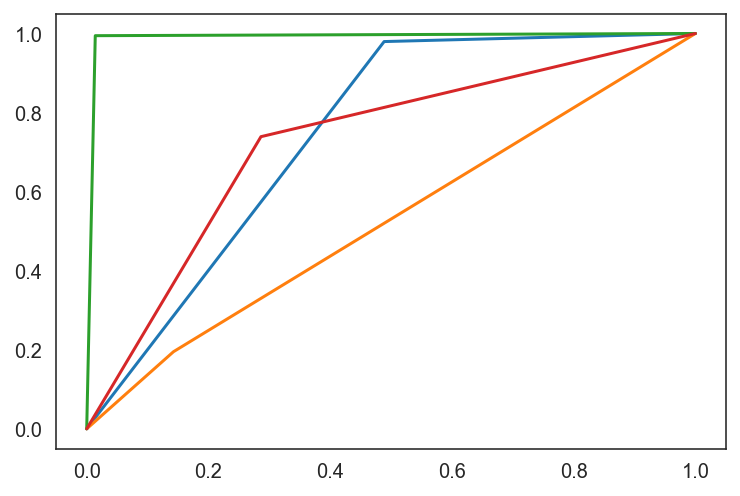

In [991]:
for i in range(len(log_reg_roc_vals_data)):
    if i == 0:
        name = "LR_AVILA"
    elif i == 1:
        name = "LR_EEG"
    elif i == 2:
        name = "LR_OCCU"
    elif i == 3:
        name = "LR_LETTER"
    plt.plot([0log_reg_roc_vals_data[i][0],1],[0,log_reg_roc_vals_data[i][1],1],label=name)
plt.show()

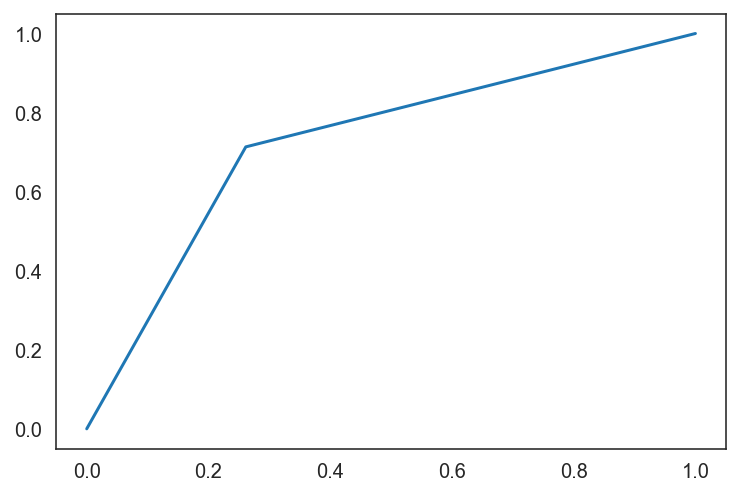

In [993]:
plt.plot(fpr,tpr)
plt.show()

In [514]:
# there were a lot of hyperparameter sets for DT, just used this to make sure nothing was awry/not too many ties
one = [0,0,0]
two = [0,0,0]
three = [0,0,0]
four = [0,0,0]
five = [0,0,0]
six = [0,0,0]
seven = [0,0,0]
eight = [0,0,0]
nine = [0,0,0]
ten = [0,0,0]

data_i = 0
trial_i = 4

for i in best_dectree_by_data[data_i][trial_i].cv_results_['rank_test_f1_micro']:
    if i == 1:
        one[1] += 1
    elif i == 2:        
        two[1] += 1
    elif i == 3:
        three[1] += 1
    elif i == 4:
        four[1] += 1
    elif i == 5:
        five[1] += 1
    elif i == 6:
        six[1] += 1
    elif i == 7:
        seven[1] += 1
    elif i == 8:
        eight[1] += 1
    elif i == 9:
        nine[1] += 1
    elif i == 10:
        ten[1] += 1
        
for i in best_dectree_by_data[data_i][trial_i].cv_results_['rank_test_roc_auc_ovr']:     
    if i == 1:
        one[2] += 1
    elif i == 2:        
        two[2] += 1
    elif i == 3:
        three[2] += 1
    elif i == 4:
        four[2] += 1
    elif i == 5:
        five[2] += 1
    elif i == 6:
        six[2] += 1
    elif i == 7:
        seven[2] += 1
    elif i == 8:
        eight[2] += 1
    elif i == 9:
        nine[2] += 1
    elif i == 10:
        ten[2] += 1        

for i in best_dectree_by_data[data_i][trial_i].cv_results_['rank_test_accuracy']:
    if i == 1:
        one[0] += 1
    elif i == 2:        
        two[0] += 1
    elif i == 3:
        three[0] += 1
    elif i == 4:
        four[0] += 1
    elif i == 5:
        five[0] += 1
    elif i == 6:
        six[0] += 1
    elif i == 7:
        seven[0] += 1
    elif i == 8:
        eight[0] += 1
    elif i == 9:
        nine[0] += 1
    elif i == 10:
        ten[0] += 1        

        
print("1: ", one, "\n2: ", two, "\n3: ", three,"\n4: ", four,"\n5: ", five,"\n6: ", six,"\n7: ", seven,"\n8: ", eight,"\n9: ", nine,"\n10: ", ten)

1:  [1, 1, 1] 
2:  [1, 1, 1] 
3:  [1, 1, 1] 
4:  [1, 1, 1] 
5:  [1, 1, 1] 
6:  [1, 1, 1] 
7:  [1, 1, 1] 
8:  [1, 1, 1] 
9:  [1, 1, 1] 
10:  [1, 1, 1]


In [517]:
best_rf_by_data[1][4].cv_results_

{'mean_fit_time': array([11.46271429, 11.29431119, 11.32947607, 11.39440274, 36.46786246,
        35.65666256,  6.64373112,  6.63992367,  8.9275959 ,  8.92514262,
        13.80256076, 13.45937891, 17.69512396, 18.04195752, 20.11038904,
        19.91704741, 13.22894216, 13.21112285, 13.55325007, 13.27415004,
        41.46789517, 41.60472412,  7.64556537,  7.87799215, 10.60360079,
        10.58217134, 15.90134616, 16.09247012, 21.05986462, 21.14847856,
        23.72878122, 21.91211243]),
 'std_fit_time': array([0.05539146, 0.04789704, 0.08633709, 0.07707696, 0.4610411 ,
        0.33881858, 0.02203739, 0.03147888, 0.01746569, 0.06160537,
        0.13066327, 0.14335565, 0.04810801, 0.21255233, 0.18046018,
        0.11438521, 0.03119574, 0.05637657, 0.16985357, 0.03942204,
        0.33390318, 0.25159209, 0.05662933, 0.06693483, 0.07007457,
        0.05309654, 0.1513985 , 0.24411376, 0.10119815, 0.19117601,
        0.06615567, 2.37611958]),
 'mean_score_time': array([0.76102672, 0.77615757, 